In [1]:
from IPython.display import HTML
HTML('''<style>html, body{overflow-y: visible !important} .CodeMirror{min-width:105% !important;} .rise-enabled .CodeMirror, .rise-enabled .output_subarea{font-size:140%; line-height:1.2; overflow: visible;} .output_subarea pre{width:110%}</style>''') # For slides

In [2]:
%matplotlib inline
from preamble import *
plt.rcParams['savefig.dpi'] = 100 # This controls the size of your figures
# Comment out and restart notebook if you only want the last output of each cell.
InteractiveShell.ast_node_interactivity = "all"

In [3]:
devnagari = oml.datasets.get_dataset(40923) # Download Devnagari data
# Get the predictors X and the labels y
X, y = devnagari.get_data(target=devnagari.default_target_attribute); 
classes = devnagari.retrieve_class_labels(target_name='character') # This one takes a while, skip if not needed

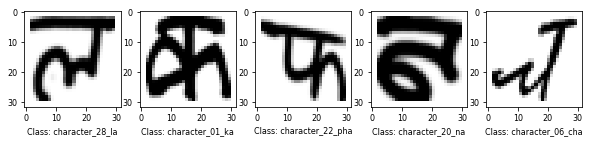

In [4]:
from random import randint
# Take some random examples, reshape to a 32x32 image and plot
fig, axes = plt.subplots(1, 5,  figsize=(10, 5))
for i in range(5):
    n = randint(0,90000)
    axes[i].imshow(X[n].reshape(32, 32), cmap=plt.cm.gray_r)
    axes[i].set_xlabel("Class: %s" % (classes[y[n]]))
plt.show();


1. Evaluate k-Nearest Neighbors, Logistic Regression and RandomForests with their default settings.
    - Take a stratified 10% subsample of the data.
    - Use the default train-test split and predictive accuracy. Is predictive accuracy a good scoring measure for this problem?
    - Try to build the same models on increasingly large samples of the dataset (e.g. 10%, 20%,...). Plot the training time and the predictive performance for each. Stop when the training time becomes prohibitively large (this will be different for different models).


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
subsample1, subsample2=next(StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=0).split(X,y))
subX,suby=X[subsample2],y[subsample2]
X_train, X_test, y_train, y_test = train_test_split(subX,suby)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [8]:
%%time
LogR = LogisticRegression()
LogR.fit(X_train, y_train)
LogR.score(X_test,y_test)

LogR.score(X_test,y_test)

0.48608695652173911

In [ ]:
%%time
LogR = LogisticRegression()
LogR.fit(X_train, y_train)
LogR_prediction = LogR.predict(X_test)
print("Predictive accuracy: {}".format(accuracy_score(y_test,LogR_prediction)))

In [38]:
from sklearn.ensemble import RandomForestClassifier

In [22]:
RF=RandomForestClassifier()
RF.fit(X_train,y_train)
RF_prediction=RF.predict(X_test)
print("Predictive accuracy: {}".format(accuracy_score(y_test,RF_prediction)))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Predictive accuracy: 0.5582608695652174


In [23]:
RF.score(X_test,y_test)

0.55826086956521737

3 . For the RandomForest, optimize both $n\_estimators$ and $max\_features$ at the same time on the entire dataset.
- Use a nested cross-validation and a random search over the possible values, and measure the accuracy. Explore how fine-grained this grid/random search can be, given your computational resources. What is the optimal performance you find?
- Hint: choose a nested cross-validation that is feasible. Don't use too many folds in the outer loop.
- Repeat the grid search and visualize the results as a plot (heatmap) $n\_estimators \times max\_features \rightarrow ACC$ with ACC visualized as the color of the data point. Try to make the grid as fine as possible. Interpret the results. Can you explain your observations? What did you learn about tuning RandomForests?

In [15]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from scipy.stats import distributions

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
sub1,sub2=next(StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=0).split(X,y))
subX,suby=X[sub2],y[sub2]

In [29]:
param_distri={'n_estimators':distributions.randint(1, 500),'max_features':distributions.uniform(0, 1)}

In [30]:
Rsearch=RandomizedSearchCV(RandomForestClassifier(),param_distributions=param_distri, n_iter=100, n_jobs=-1, cv=3,scoring='accuracy')

In [31]:
X1,y1=X[:10],y[:10]
scores=cross_val_score(Rsearch,X1, y1, cv=3)
print("scores {}" .format(scores))

scores [ 1.  1.  1.  1.  1.]


In [40]:
%%time
scores=cross_val_score(Rsearch,X, y, cv=5)

KeyboardInterrupt: 

In [13]:
from sklearn.model_selection import GridSearchCV 
param_grid={'n_estimators':[2**i for i in range(9)],'max_features':np.arange(0.05, 1.0, 0.05)}
gridcv=GridSearchCV(RandomForestClassifier(), param_grid, cv=3, n_jobs=-1, scoring='accuracy')

In [ ]:
gridcv.fit(X, y)

In [34]:
grid_scores=np.array(gridcv.cv_results_['mean_test_score']).reshape(
    len(param_grid['max_features']),
    len(param_grid['n_estimators'])).T
mglearn.tools.heatmap=(grid_scores, xlabel='max_features', xticklabels=param_grid['max_features'],
                      ylabel='n_estimator', yticklabels=param_grid['n_estimator'], cmap="inferno");

array([ 0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,  0.45,
        0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,  0.9 ,  0.95])

In [6]:
def subsample(precent,X,y):
    _,index=next(StratifiedShuffleSplit(test_size=precent, random_state=0).split(X,y))
    subX,suby=X[index],y[index]
    X_train, X_test, y_train, y_test = train_test_split(subX,suby)
    return X_train, X_test, y_train, y_test

In [10]:
def toolong(time):
    if(time/60.0 > 30):
        flag=0
    else:
        flag=1
    return flag

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from time import process_time

In [ ]:

knn_time,knn_acc=[],[]
lgr_time,lgr_acc=[],[]
rf_time,rf_acc=[],[]
precentlist=np.arange(0.1,1.0,0.1)
knn,lgr,rf=1,1,1
for precent in precentlist:
    if(knn or lgr or rf):
        X_train, X_test, y_train, y_test=subsample(precent,X,y)
    if(knn):
        start=process_time()
        knn=KNeighborsClassifier().fit(X_train, y_train)
        traintime=process_time()-start
        print("kkn precent:{:0.1f},time:{:0.2f}" .format(precent,traintime/60))
        knn_time.append(traintime)
        knn_acc.append(knn.score(X_test,y_test))
        knn=min(toolong(traintime),toolong(scoretime))
    if(lgr):
        start=process_time()
        lgr = LogisticRegression().fit(X_train, y_train)
        traintime=process_time()-start
        print("lgr precent:{:0.1f},time:{:0.2f}" .format(precent,traintime/60))
        lgr_time.append(traintime)
        lgr_acc.append(lgr.score(X_test,y_test))
        lgr=min(toolong(traintime),toolong(scoretime))
    if(rf):
        start=process_time()
        rf=RandomForestClassifier().fit(X_train,y_train)
        traintime=process_time()-start
        print("rf precent:{:0.1f},time:{:0.2f}" .format(precent,traintime/60))
        rf_time.append(traintime)
        rf_acc.append(rf.score(X_test,y_test))
        rf=min(toolong(traintime),toolong(scoretime))

kkn precent:0.1,time:0.01
lgr precent:0.1,time:3.66
rf precent:0.1,time:0.01
kkn precent:0.2,time:0.04
lgr precent:0.2,time:58.46
rf precent:0.2,time:0.03
kkn precent:0.3,time:0.08
rf precent:0.3,time:0.05
kkn precent:0.4,time:0.13
rf precent:0.4,time:0.06
kkn precent:0.5,time:0.19
rf precent:0.5,time:0.09
kkn precent:0.6,time:0.28
rf precent:0.6,time:0.10
kkn precent:0.7,time:0.40
rf precent:0.7,time:0.11
kkn precent:0.8,time:0.44
rf precent:0.8,time:0.13
kkn precent:0.9,time:0.54


In [17]:
X_train, X_test, y_train, y_test=subsample(0.8,X,y)
knn=KNeighborsClassifier().fit(X_train, y_train)

In [18]:
%%time
knn.score(X_test,y_test)

CPU times: user 27min 57s, sys: 11.5 s, total: 28min 8s
Wall time: 28min 36s


0.89809782608695654

In [11]:
a=min(toolong(1900),toolong(180))

In [118]:
a=[0.2,0.3,50,0.1,0.2,0.3,0.3,0.4,0.1]
b=[0.1,0.3,0.4]

In [72]:
cc="abcds"

In [97]:
def showpic(axes,i,x,y,mark,label,yl,xl,t):
    axes[i].plot(x, y, mark,label=label)
    axes[i].set_ylabel(yl)
    axes[i].set_xlabel(xl)
    axes[i].set_title(t)
    axes[i].legend()

In [85]:
showpic(axes,0,[(i+1)*0.1 for i in range(len(a))],a,'ro',"k-nearest  trainning time",cc,"n_estimators","RandomForests Classifier")

TypeError: imshow() missing 1 required positional argument: 'X'

In [83]:
plt.show()

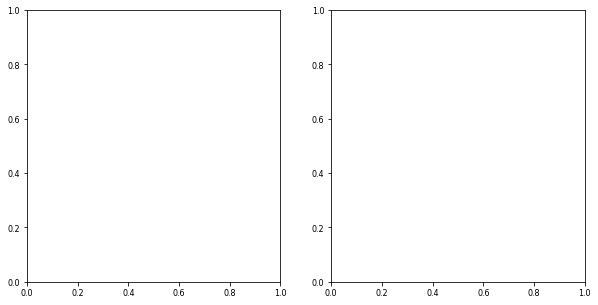

Text(0.5,0.98,'asaad')

AttributeError: Unknown property figsize

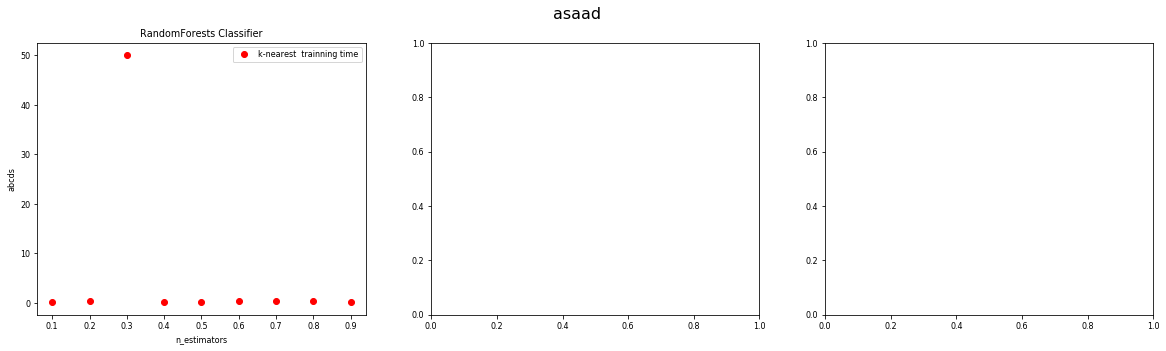

In [120]:

fig1, axes = plt.subplots(1, 3,  figsize=(20, 5))
plt.suptitle("asaad", fontsize=16)
showpic(axes,0,[(i+1)*0.1 for i in range(len(a))],a,'ro',"k-nearest  trainning time",cc,"n_estimators","RandomForests Classifier")
#axes[0].plot([(i+1)*0.1 for i in range(len(a))], a, 'ro',label="k-nearest  trainning time")
#axes[0].set_ylabel("predictive accuracy")
#axes[0].set_xlabel("n_estimators")
#axes[0].set_title("RandomForests Classifier")
#axes[0].legend()


axes[1].plot([(i+1)*0.1 for i in range(len(b))], b, 'g^',label="k-nearest neighbour's trainning time")
axes[1].set_ylabel("predictive accuracy")
axes[1].set_xlabel("n_estimators")
axes[1].set_title("RandomForests Classifier")
axes[1].legend(bbox_to_anchor=(1.05, 1), loc=3, borderaxespad=0.)

showpic(axes,2,[(i+1)*0.1 for i in range(len(a))],a,'ro',"k-nearest  trainning time",cc,"n_estimators","RandomForests Classifier")
#axes[0].plot([(i+1)*0.1 for i in range(len(a))], a, 'ro',label="k-nearest  trainning time")

fig1, axes = plt.subplots(1, 2,  figsize=(20, 5))
plt.suptitle("asaad", fontsize=16)
showpic(axes,0,[(i+1)*0.1 for i in range(len(a))],a,'ro',"k-nearest  trainning time",cc,"n_estimators","RandomForests Classifier")
#axes[0].plot([(i+1)*0.1 for i in range(len(a))], a, 'ro',label="k-nearest  trainning time")
#axes[0].set_ylabel("predictive accuracy")
#axes[0].set_xlabel("n_estimators")
#axes[0].set_title("RandomForests Classifier")
#axes[0].legend()


axes[1].plot([(i+1)*0.1 for i in range(len(b))], b, 'g^',label="k-nearest neighbour's trainning time")
axes[1].set_ylabel("predictive accuracy")
axes[1].set_xlabel("n_estimators")
axes[1].set_title("RandomForests Classifier")
axes[1].legend(bbox_to_anchor=(1.05, 1), loc=3, borderaxespad=0.)